In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib

import scipy.fftpack as fftp
import os

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [159]:
folder_loc = 'Data/2019-10-17/'
file_loc = '2019-10-17 Calibration spec A'

dat_cal = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=119)
count = 1
for j in arange(2,250):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file,skiprows=119)
        dat_cal = np.concatenate((dat_cal,temp_dat))
    except:
        pass
    
dat = np.loadtxt(folder_loc+file_loc+'250'+'.dat',skiprows=119)    
    
for j in arange(251,290):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file,skiprows=119)
        dat = np.concatenate((dat,temp_dat))
    except:
        pass

In [160]:
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

In [161]:
cur_cal = dat_cal[:,0]
geo_cal = dat_cal[:,1]
tip_cal = dat_cal[:,2]
lix_cal = dat_cal[:,3]
liy_cal = dat_cal[:,4]

cur = dat[:,0]
geo = dat[:,1]
tip = dat[:,2]
lix = dat[:,3]
liy = dat[:,4]
print(len(geo_cal),len(tip_cal))


6225000 6225000


-18645329012.076466


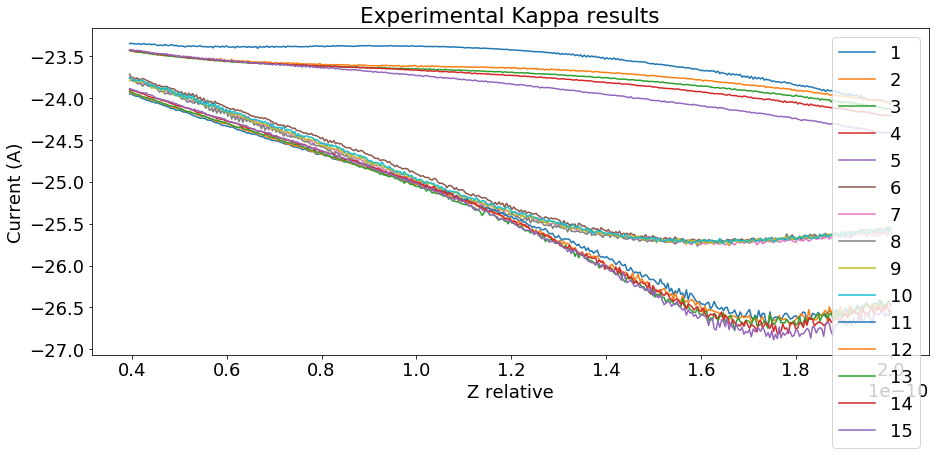

In [88]:
file_loc = 'Z-Spectroscopy'
temp_dat = np.loadtxt(folder_loc+file_loc+'00001'+'.dat',skiprows=119)   
plot(temp_dat[:,0],log(abs(temp_dat[:,1])),label=str(1))
for j in arange(2,16):
    file = folder_loc+file_loc+str(j).zfill(5)+'.dat'
    try:
        temp_dat = np.loadtxt(file,skiprows=119)
        plot(temp_dat[:,0],log(abs(temp_dat[:,1])),label=str(j))
        #kappa = np.concatenate((dat,temp_dat))
    except:
        pass
xlabel('Z relative')
ylabel('Current (A)')
title('Experimental Kappa results')
legend()

kappa = np.loadtxt(folder_loc+file_loc+'00011'+'.dat',skiprows=119)  

kap_z = kappa[:,0]
kap_cur = kappa[:,1]
fit = polyfit(kap_z,log(abs(kap_cur)),1)
print(fit[0])
#cut kappa to make it look like a line
#take best from before and best from after 
#compare

In [157]:
nc = cancel.Cancel(geo_cal,tip_cal,(1/10000),p=[5000,2500,5])
transf = nc.transf
freqs = nc.freqs

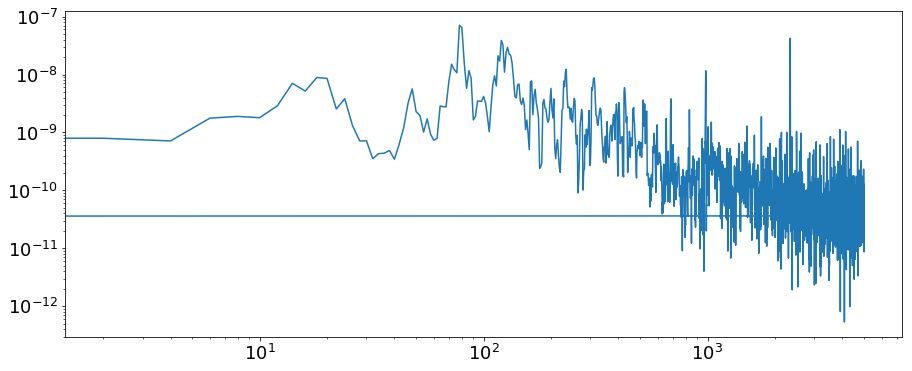

In [158]:
loglog(nc.freqs[:100000],absolute(nc.transf(nc.freqs[:100000])))

In [82]:
z_noise=create_drive(geo,1/10000,transf,freqs)
cur_noise=exp(-(z_noise-mean(z_noise))*fit[0])

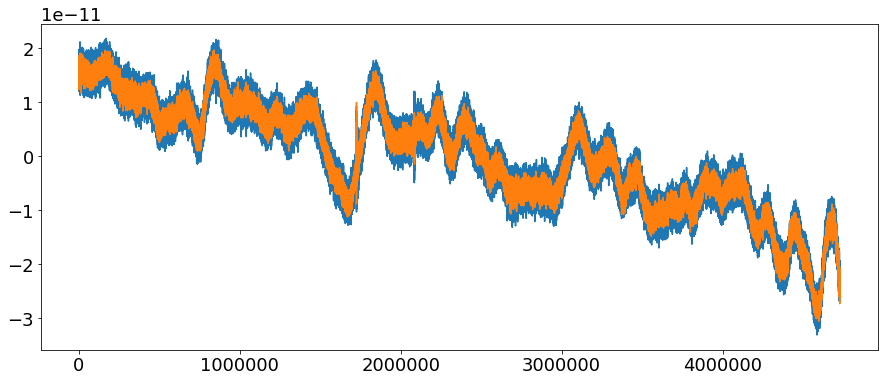

In [83]:
plot(tip-mean(tip))
#plot(z_noise-mean(z_noise))
plot((tip-mean(tip))-(z_noise-mean(z_noise)))

No handles with labels found to put in legend.


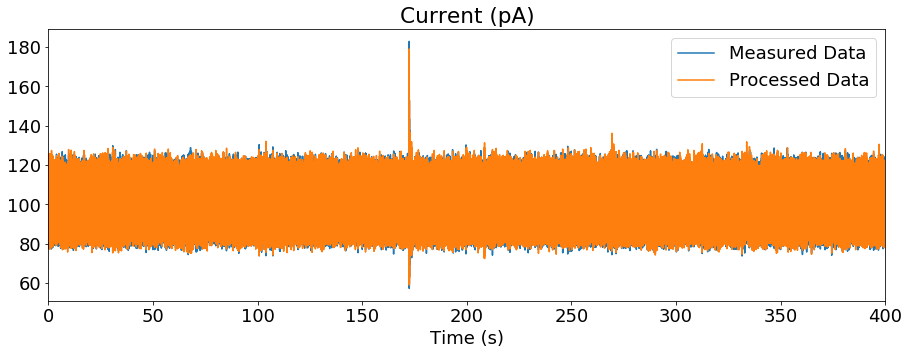

In [84]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

figsize(15,5)
title('Current (pA)')
xlabel('Time (s)')
legend()

start=0
end=4000000

t=linspace(0,(start-end)/-10000,end-start)

delay=0 # a delay may be necessary to compensate for any time-effects between geophone/Z and current data
plot(t,cur[start:end]*1e12,label='Measured Data')
plot(t,cur[start:end]/cur_noise[start+delay:end+delay]*1e12,label='Processed Data')
xlim(0,(end-start)/10000)
legend()

#dont divide
#make simulated LIY the same as the Nanonis LIY

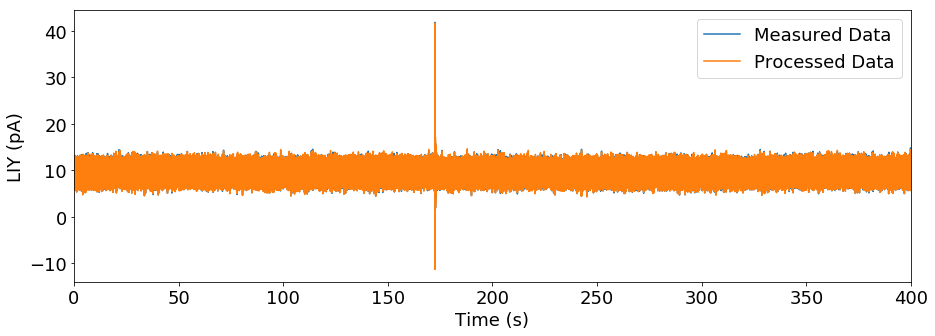

In [85]:
start=0
end=4000000

t=linspace(0,(end-start)/10000,end-start)

figsize(15,5)
plot(t,liy[start:end]*1e12,label='Measured Data')

# not sure why there exists a delay between liy and cur_noise
delay=32
del2 = 0
plot(t[:-delay],liy[start:end-delay]/(repeat(mean(cur_noise[start+delay+del2:end+del2].reshape(-1,8),axis=1),8))*1e12,label='Processed Data')
xlabel('Time (s)')
xlim(0,(end-start)/10000)
ylabel('LIY (pA)')
legend()

4728000 4728000


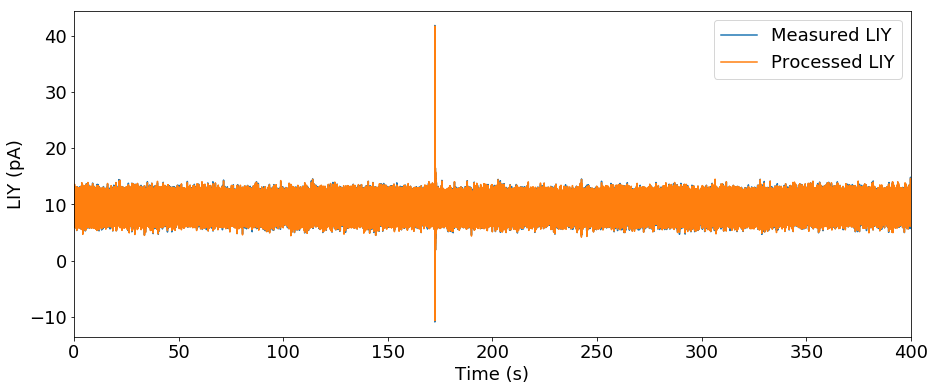

In [86]:
figsize(15,6)
start=0
end=4000000

t=linspace(0,(end-start)/10000,end-start)


liy_canceled = cancel.Cancel(geo_cal-mean(geo_cal), fit_cancel(liy_cal), 1/10000, p=[200000,100000,5])
normalized_geo = geo[:end]-mean(geo[:end])
canceled_drive = liy_canceled.create_drive(geo[:end]-mean(geo[:end]))
filtered = stmpy.tools.butter_lowpass_filter(liy_canceled.create_drive(geo[:end]-mean(geo[:end])), ncutoff=300/10000)*1e12

print(len(stmpy.tools.butter_lowpass_filter(liy_canceled.create_drive(geo-mean(geo)))),len(liy))

plot(t,liy[:end]*1e12, label='Measured LIY')

plot(t,liy[:end]*1e12-filtered,label='Processed LIY')
xlim(0,(end-start)/10000)
ylabel('LIY (pA)')
xlabel('Time (s)')
legend()

C:\Users\jgoet\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


NameError: name 'lengend' is not defined

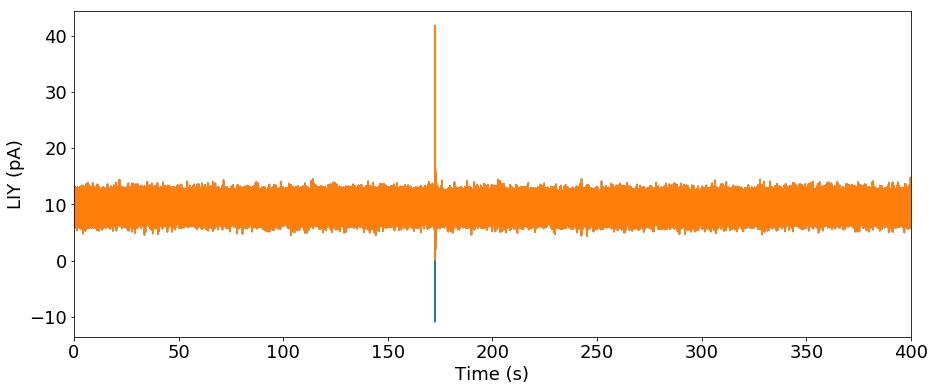

In [140]:
figsize(15,6)
init=2000000
tester=2000000
cancel_fit = fit_cancel(log(abs(liy_cal[:800000])))
logliy_canceled = cancel.Cancel(geo_cal[:]-mean(geo_cal[:]), fit_cancel(log(abs(liy_cal[:]))), 1/10000, p=[200000,50000,5])
plot(t,liy[:end]*1e12,label='Measured LIY')
# plot(exp(log(liy[tester:])-test_trx.create_drive(geo[tester:]-mean(geo[tester:]))),'r',label='Processed',alpha=0.5)
plot(t,exp(log(liy[:end])-stmpy.tools.butter_lowpass_filter(test_trx.create_drive(geo[:end]-mean(geo[:end]))))*1e12,label='Processed LIY')
xlim(0,400)

xlabel('Time (s)')
ylabel('LIY (pA)')
lengend()

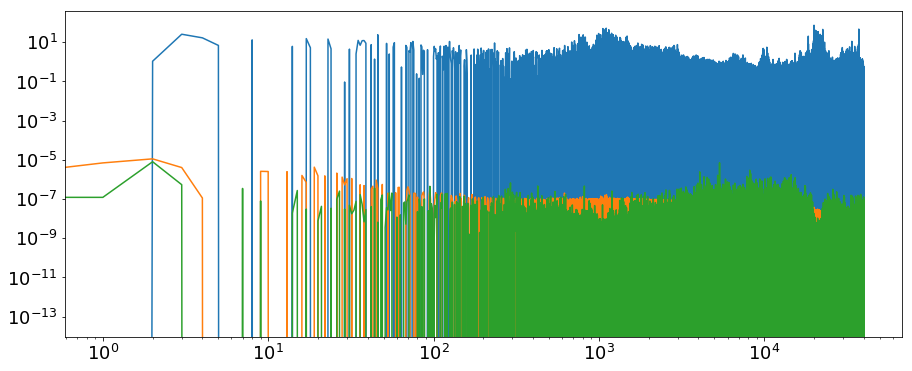

In [177]:
fft_liy = fft.fft(tip_cal)
fft_geo = fft.fft(geo_cal)


loglog(fft_geo[:40000])
loglog(fft_liy[:40000])
loglog(fft_liy[:40000]/fft_geo[:40000])

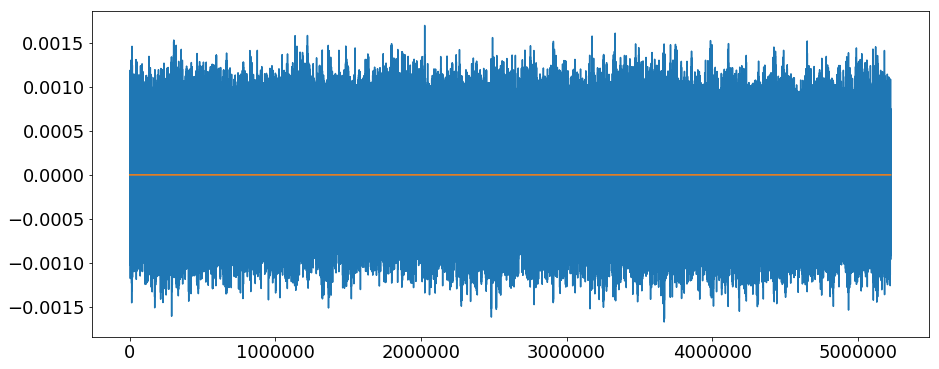

In [183]:
plot(geo_cal[1000000:]-mean(geo_cal[1000000:]))
plot(tip_cal[1000000:]-mean(tip_cal[1000000:]))
